In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, train_test_split

# Read in the CL data

In [2]:
# df = pd.read_csv('data/no_dupes_lda_fit5_18.csv')
# This has the latest preproc texts
df = pd.read_csv('5_22_preproc.csv')

In [22]:
len(df)

14748

In [18]:
# Compare count and overlap
black = df.index[df['high_black'] == True].tolist()
white = df.index[df['high_white'] == True].tolist()
asian = df.index[df['high_asian'] == True].tolist()

In [17]:
# Should I remove these from analysis?
len(set(black).intersection(set(white)))

2196

In [25]:
overlap = sorted(list(set(black).intersection(set(white))))

In [30]:
df = df.drop(df.index[overlap])

In [31]:
len(df)

12552

In [19]:
len(set(black).intersection(set(asian)))

3168

In [20]:
len(set(white).intersection(set(asian)))

1218

In [13]:
len(black)

6385

In [14]:
len(white)

8144

In [21]:
len(asian)

6208

woah, asian & white neighbs have the lowest overlap

# 0. Are titles alone predictive?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['listingTitle'], df['high_white'], random_state=0)

In [ ]:
word_vectorizer = CountVectorizer()
word_vectorizer.fit(X_train)
X_train_vectorized = word_vectorizer.transform(X_train)
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

# Not really.

# Read in neighborhood names

In [ ]:
with open('resources/hoods.txt', 'r') as inf:
    hoodnames = inf.read().splitlines()
    #hoodnames = inf.read()
    #hoodnames = re.split(r',\s*', hoodnames)

# Curated list of Seattle-area neighborhoods -- some manually added in.

In [ ]:
neighbs = """"'Adams' 'Alki' 'Arbor Heights' 'Atlantic' 'Ballard' 'Belltown' 'Bellevue' Bitter Lake'
 'Bothell' 'Bremerton' 'Briarcliff' 'Brighton' 'Broadview' 'Broadway' 'Bryant' 'Capitol Hill' 'Cedar Park'
 'Central Business District' 'Columbia City' 'Crown Hill' 'Dunlap'
 'East Queen Anne' 'Eastlake' 'Everett' 'Fairmount Park' 'Fauntleroy' 'Federal Way' 'First Hill'
 'Fremont' 'Gatewood' 'Genesee' 'Georgetown' 'Green Lake' 'Greenlake' 'Greenwood'
 'Haller Lake' 'Harrison/Denny-Blaine' 'High Point' 'Highland Park'
 'Holly Park' 'Industrial District' 'Interbay' 'International District' 'Issaquah' 'Kirkland'
 'Laurelhurst' 'Lawton Park' 'Leschi' 'Lower Queen Anne' 'Loyal Heights'
 'Madison Park' 'Madrona' 'Mann' 'Maple Leaf' 'Matthews Beach'
 'Meadowbrook' 'Mid-Beacon Hill' 'Mill Creek' Minor' 'Montlake' 'Mount Baker' 'Newcastle'
 'North Admiral' 'North Beach/Blue Ridge' 'North Beacon Hill'
 'North College Park' 'North Delridge' 'North Queen Anne' 'Olympic Hills'
 'Phinney Ridge' 'Pike-Market' 'Pinehurst' 'Pioneer Square' 'Portage Bay'
 'Rainier Beach' 'Ravenna' 'Redmond' 'Renton' 'Riverview' 'Roosevelt' 'Roxhill' 'Seaview'
 'Seward Park' 'Shoreline' 'South Beacon Hill' 'South Delridge' 'South Lake Union'
 'South Park' 'Southeast Magnolia' 'Stevens' 'Sunset Hill'
 'University District' 'U District' 'UDistrict' 'Victory Heights' 'View Ridge' 'Wallingford'
 'Wedgwood' 'West Seattle' 'West Queen Anne' 'West Woodland' 'Westlake'
 'Whittier Heights' 'Windermere' 'Yesler Terrace'""".split("'")

In [ ]:
hoods = [name.lower() for name in neighbs if re.match(r'\w+', name)]

In [ ]:
hoods

# Preprocess the data:
- Strip URLs (or.. should map them to '#url' ???)
- Map neighborhood names to '#hood'
- Tokenize words & punctuation


- don't use 'clean_text' yet since it has some preproc errors

In [ ]:
#url_pattern = r'(https?:\/\/)?(www)?.*[\r\n]*'


url_pattern = r'(http)?(www)?\S*(\.com|\.net|\.gov|\.be|\.org)\S*'

In [ ]:
punctuation_pattern = r"[#\w'-]+|[.,!?;]+"

In [ ]:
def preprocess(text):
    text = text.lower()
    no_urls = re.sub(url_pattern, '', text)
    for hood in hoodnames:
        # hood_pattern = r'\s+{0}\s+'.format(hood)
        #hood_pattern = r' ?'+hood+' ?'
        # Match neighborhood mentions surrounded by whitespace and replace with #hood
        no_urls = re.sub(r'\W+{0}\W+'.format(hood), ' #hood ', no_urls)
    no_digits = re.sub(r'\d+', '', no_urls)
    tokenized = re.findall(punctuation_pattern, no_digits)
    return ' '.join([word.lower() for word in tokenized])

In [ ]:
short_example = "this queen anne apartment is really cool !!! 98105 https://blah.com"

In [ ]:
long_example = df.loc[0]['body_text']

In [ ]:
preprocess(short_example)

In [ ]:
preprocess(long_example)

In [ ]:
texts = [[word for word in text.lower().split() if word not in hoodnames] for text in df.clean_text]

In [ ]:
# Apply preproc to all texts
df['preproc_text'] = df['body_text'].apply(preprocess)

In [ ]:
# Save her for faster loading!
df.to_csv('5_22_preproc.csv')

# Train & test models.
## Split the data into train & test sets
## First, binary classif: high white vs not

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_white'], random_state=0)

In [33]:
word_vectorizer = CountVectorizer()

In [34]:
X_train_vectorized = word_vectorizer.fit_transform(X_train)

In [35]:
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)

In [36]:
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]

In [37]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [38]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8585733877561657
F1 score:  0.7699530516431925
accuracy:  0.781389420012747


In [39]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

(0.0, 1.0)

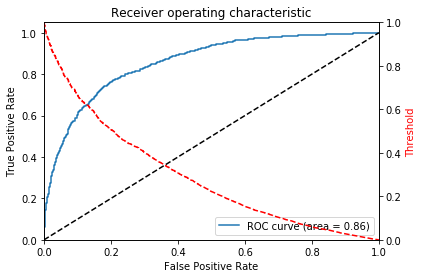

In [40]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [41]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['rail' 'westwood' 'concierge' 'marymoor' 'mall' 'airport' 'rianna' 'moda'
 'aurora' 'harbor' 'riverpark' 'somerset' 'pools' 'jefferson' 'cedar'
 'stadiums' 'fountain' 'cleveland' 'borgata' 'grand']

Largest Coefs: 
['country' 'zoo' 'boutiques' 'domaine' 'village' 'esxpt' 'children'
 'inglenook' 'bernard' 'woodland' 'volunteer' 'northshore' 'point' 'odin'
 'springline' 'waterscape' 'beach' 'locks' 'urbana' 'nw']


In [43]:
# Five-fold cross validation
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_white']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    word_vectorizer.fit(X_train)
    X_train_vectorized = word_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(word_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()

    # Find the 10 smallest and 10 largest coefficients
    # The 10 largest coefficients are being indexed using [:-11:-1]
    # so the list returned is in order of largest to smallest
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: np.nan is an invalid document, expected byte or unicode string.

# Using ngram features

In [44]:
# remake train test split
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_white'], random_state=0)

In [45]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,4)).fit(X_train)

In [46]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
#model = LogisticRegression(C=.5).fit(X_train_ngrams, y_train)
model = LogisticRegression(C=.5, penalty='l2').fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]

In [47]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [48]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8898234895546601
F1 score:  0.798804780876494
accuracy:  0.8068833652007649


In [49]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['mall' 'rail' 'airport' 'light rail' 'concierge' 'south'
 'hood university' 'gym' 'shopping' 'center' 'college' 'marymoor'
 'th ave hood' 'story' 'south hood' 'section' 'near' 'marymoor park'
 'to shopping' 'westwood']

Largest Coefs: 
['uw' 'ave nw' 'children' 'locks' 'hood beach' 'west' 'charming'
 'hood ave' 'basement' 'point' 'smoking' 'laundry' 'village' 'on hood'
 'deck' 'hood village' 'market' 'shops' 'beach' 'nw']


In [50]:
# CV with ngram on high white
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_white']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_vectorized = ngram_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.5).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(ngram_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()

    # Find the 10 smallest and 10 largest coefficients
    # The 10 largest coefficients are being indexed using [:-11:-1]
    # so the list returned is in order of largest to smallest
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
# AP note (04/14) The neighborhood names are still not complete enough -_-
# also they are still sneaking in somehow... need more work on preproc
# 'kirkland' and 'issaquah' are IN the damn hoods list.. why are they still showing up?!
# 5/22: updated regex in preproc, does much better now!

# OK, that was a binary prediction on high-white; let's see high-black

In [51]:
# Prob a faster way to just grab new labels...
X_train, X_test, y_train, y_test = train_test_split(df['preproc_text'], df['high_black'], random_state=0)

In [52]:
X_train_ngrams = ngram_vectorizer.transform(X_train)
# Logistic regression model
model = LogisticRegression(C=.5).fit(X_train_ngrams, y_train)
predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]


#Parameters to try: l1 penalty instead of l2
# different regularization 

In [53]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [54]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.9070896497141245
F1 score:  0.7472647702407001
accuracy:  0.8527724665391969


In [55]:
feature_names = np.array(ngram_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['nw' 'ne' 'beach' 'uw' 'trails' 'trail' 'school hood' 'hood square'
 'newport' 'island' 'courtyard' 'hood trail' 'blocks' 'hood beach' 'old'
 'shops' 'hood park' 'car garage' 'ride' 'hardwood floors']

Largest Coefs: 
['gated' 'college' 'freeway' 'hood station' 'aurora' 'golf' 'ave hood'
 'north hood' 'rianna' 'station' 'th ave hood' 'mall' 'court' 'south'
 'concierge' 'light rail' 'south hood' 'airport' 'hood university' 'rail']


In [56]:
X_train_vectorized = word_vectorizer.transform(X_train)
model = LogisticRegression(C=.1, penalty='l1').fit(X_train_vectorized, y_train)
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.8560934278030323
F1 score:  0.6311522872032427
accuracy:  0.7970044614404079


In [57]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['nw' 'newport' 'ne' 'trader' 'winning' 'trails' 'gilman' 'volunteer'
 'beach' 'se' 'comprehensive' 'marymoor' 'trail' 'lincoln' 'surrey' 'coin'
 'springline' 'urbana' 'september' 'uw']

Largest Coefs: 
['mall' 'cityline' 'swedish' 'hills' 'stadiums' 'cedar' 'aurora' 'olympus'
 'helios' 'centennial' 'southcenter' 'sculpture' 'jefferson' 'concierge'
 'rail' 'airport' 'westwood' 'rianna' 'harbor' 'moda']


In [ ]:
y_test.value_counts()


In [ ]:
1627/2060

In [ ]:
# Try SVM..

model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
model.fit(X_train_vectorized,y_train)
predicted = model.predict(word_vectorizer.transform(X_test))
np.mean(predicted == y_test)

In [ ]:
model.score(word_vectorizer.transform(X_test), y_test)

In [ ]:
# Five-fold cross validation on unigrams
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_black']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    word_vectorizer.fit(X_train)
    X_train_vectorized = word_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.5).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(word_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

In [46]:
# CV with ngram
kf = KFold(n_splits=5)
X, y = df['preproc_text'], df['high_black']
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_vectorized = ngram_vectorizer.fit_transform(X_train)
    model = LogisticRegression(C=.5).fit(X_train_vectorized, y_train)
    predictions = model.predict_proba(ngram_vectorizer.transform(X_test))[:,1]
    binary_pred = [0 if value <= 0.5 else 1 for value in predictions]
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('F1 score: ', f1_score(y_test, binary_pred))
    print('accuracy: ', accuracy_score(y_test, binary_pred))
    feature_names = np.array(ngram_vectorizer.get_feature_names())

    # Sort the coefficients from the model
    sorted_coef_index = model.coef_[0].argsort()
    print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
    print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

AUC:  0.8570017743120733
F1 score:  0.7233669443226654
accuracy:  0.7861016949152543
Smallest Coefs:
['nw' 'ne' 'hood square' 'uw' 'trails' 'newport' 'se' 'school hood'
 'mountains' 'beach' 'shops' 'hood park' 'trail' 'ave nw' 'courtyard'
 'square' 'ne hood wa' 'tour today' 'zoo' 'excellent']

Largest Coefs: 
['flooring' 'elliott' 'mall' 'moda' 'olive' 'hood station' 'ave hood'
 'harbor' 'pointe' 'th ave hood wa' 'south hood' 'golf' 'station'
 'th ave hood' 'concierge' 'court' 'light rail' 'airport'
 'hood university' 'rail']
AUC:  0.860598941466387
F1 score:  0.7143507972665147
accuracy:  0.7874576271186441
Smallest Coefs:
['nw' 'ne' 'uw' 'hood square' 'trails' 'school hood' 'hood park' 'se'
 'shops' 'beach' 'island' 'newport' 'square' 'ave nw' 'mountains' 'nw th'
 'zoo' 'starting' 'ne hood' 'trail']

Largest Coefs: 
['hood airport' 'south' 'golf course' 'the hood hood' 'community college'
 'valley' 'ave hood' 'olive' 'concierge' 'court' 'south hood'
 'hood station' 'station' 'pointe'